In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23')

In [11]:
latest_date = '2017-08-23'

last_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

last_date

datetime.datetime(2017, 8, 23, 0, 0)

In [12]:
# Calculate the date 1 year ago from the last data point in the database
yrbfr_date = last_date - timedelta(days=365)

first_date = yrbfr_date.strftime('%Y-%m-%d')

print(first_date)


2016-08-23


In [49]:
# Design a query to retrieve the last 12 months of precipitation data
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > first_date).\
    order_by(Measurement.date).all()

In [50]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.head()

,date,precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


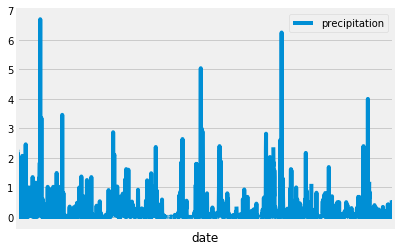

In [51]:
# Use Pandas Plotting with Matplotlib to plot the data
df.set_index('date', inplace=True)
df.plot()
plt.xticks([])
plt.savefig('./Images/prcp.png')
plt.show()

In [52]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df["precipitation"].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

In [53]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(Station.station).count()

station_count

9

In [54]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [61]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature recorded from the most active station
station_active_most = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == station_active[0][0]).all()

station_active_most

[(54.0, 85.0, 71.66378066378067)]

In [62]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.date).filter(Measurement.station == station_active[0][0]).order_by(Measurement.date.desc()).first()


('2017-08-18')

In [63]:
latest_date_t = '2017-08-18'

last_date_t = dt.datetime.strptime(latest_date_t, '%Y-%m-%d')

yrbfr_date_t = last_date_t - timedelta(days=365)

first_date_t = yrbfr_date_t.strftime('%Y-%m-%d')

print(first_date_t)


2016-08-18


In [64]:
results_s = session.query(Measurement.tobs).filter(Measurement.date > first_date_t, Measurement.station == station_active[0][0]).order_by(Measurement.tobs.desc()).all()


In [65]:
tobs = results_s[0]
df_tobs = pd.DataFrame(results_s, columns=['tobs'])
df_tobs.head()

,tobs
0,83.0
1,82.0
2,82.0
3,82.0
4,81.0


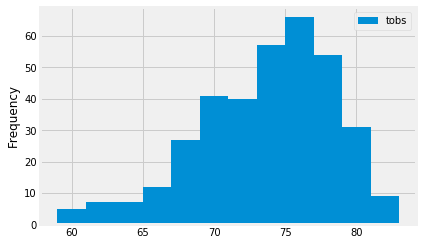

In [66]:
df_tobs.plot.hist(tobs, bins=12)
plt.ylabel('Frequency')
plt.savefig('./Images/tobs.png')
plt.show()

#  Optional Challenge Assignment #

In [67]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = input("A start date in 'YYYY-MM-DD' format: ")
end_date = input("An end date in 'YYYY-MM-DD' format: ")

A start date in 'YYYY-MM-DD' format: 2016-02-28
An end date in 'YYYY-MM-DD' format: 2016-03-05


In [68]:
# Select the values to query
sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
# Query the data
start_end_tobs = session.query(*sel).filter(Measurement.date > start_date, Measurement.date < end_date).all()

start_end_tobs

[(62.0, 69.57575757575758, 79.0)]

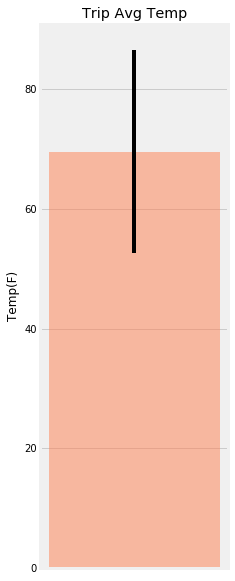

In [69]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin = start_end_tobs[0][0]
tavg = start_end_tobs[0][1]
tmax = start_end_tobs[0][2]
y_err = tmax-tmin

plt.figure(figsize=(3,10))
plt.bar(0, tavg, yerr=y_err, align="center", color="coral", alpha=0.5)
plt.ylim=(0,120)
plt.ylabel("Temp(F)")
plt.title("Trip Avg Temp")
plt.xticks([])
plt.savefig('./Images/PTP.png')
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.


In [ ]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
